In [1]:
import celldancer as cd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Simulation of genes

In [2]:
def simulate_kinetics(gene, alpha, beta, gamma, start_u, start_s, n_cells=2000, start_pct=0, end_pct=99, noise_level=0, plot=False):
    gene_info = pd.DataFrame(
        columns = [
            'gene_name', 
            'start_u', 
            'start_s', 
            'alpha', 
            'beta', 
            'gamma', 
            'start_pct', 
            'end_pct', 
            'samples'
            ])

    cell_induction = int(n_cells*0.5)
    cell_repression = n_cells - cell_induction

    gene_info = gene_info.append(
        {'gene_name':gene, 
        'start_u':start_u, 
        'start_s':start_s, 
        'alpha':alpha, 
        'beta':beta, 
        'gamma':gamma, 
        'start_pct':start_pct, 
        'end_pct':end_pct, 
        'samples':cell_induction}, 
        ignore_index=True)
    
    gene_info = gene_info.append(
        {'gene_name':gene, 
        'start_u':None, 
        'start_s':None, 
        'alpha':0, 
        'beta':beta, 
        'gamma':gamma, 
        'start_pct':start_pct, 
        'end_pct':end_pct, 
        'samples':cell_repression}, 
        ignore_index=True)
    
    gene_info, expr = cd.simulation.generate_with_df(gene_info, noise_level=noise_level)
    if plot:
        plt.scatter(expr['s0'], expr['u0'], c=expr['alpha'], s=1)
        plt.show()
    expr['gene_name']=[gene]*n_cells
    return expr

In [3]:
def simulate_raw_reads(df, n_generate=30, distr='NB', NB_prob=0.5, inplace=False):
    # assuming each cell along the cycle is an averaged reads from 30 cells
    # After this, df will be expanded to 30*n_cells

    u = df['u0'].to_numpy()
    s = df['s0'].to_numpy()

    if distr == 'NB':
        sigma_u = NB_prob
        sigma_s = NB_prob
        u_raw = np.array([np.random.negative_binomial(mu, sigma_u, size = n_generate) if mu > 0 else [0]*n_generate for mu in u])
        s_raw = np.array([np.random.negative_binomial(ms, sigma_s, size = n_generate) if ms > 0 else [0]*n_generate for ms in s])
    
    if distr == 'Poisson':
        u_raw = np.array([np.random.poisson(mu, size=n_generate) for mu in u])
        s_raw = np.array([np.random.poisson(ms, size=n_generate) for ms in s])

    if inplace:
        df['u_raw'] = u_raw.tolist()
        df['s_raw'] = s_raw.tolist()
        df['u_sim_mean'] = np.mean(u_raw, axis=1).tolist()
        df['s_sim_mean'] = np.mean(s_raw, axis=1).tolist()

        return df
    else:
        df_simulate_raw = df.copy()
        df_simulate_raw['u_raw'] = u_raw.tolist()
        df_simulate_raw['s_raw'] = s_raw.tolist()   
        df_simulate_raw['u_sim_mean'] = np.mean(u_raw, axis=1).tolist()
        df_simulate_raw['s_sim_mean'] = np.mean(s_raw, axis=1).tolist()

        return df_simulate_raw

In [4]:
def calc_dropout(df, col_handle='_raw'):
    u_raw_nonzero = df['u'+col_handle][df['u0']>0]
    s_raw_nonzero = df['s'+col_handle][df['s0']>0]

    u_raw_nonzero = np.array([i for i in u_raw_nonzero])
    s_raw_nonzero = np.array([i for i in s_raw_nonzero])


    nonzeros_u = np.count_nonzero(u_raw_nonzero)
    nonzeros_s = np.count_nonzero(s_raw_nonzero)

    n_generate = u_raw_nonzero.shape[1]
    n_cells_total = len(df)*n_generate

    u_zeros = u_raw_nonzero.shape[0] * n_generate - nonzeros_u
    s_zeros = s_raw_nonzero.shape[0] * n_generate - nonzeros_s

    return u_zeros/n_cells_total, s_zeros/n_cells_total

### Let's start with three simple cases, with (s,u)max in the category < 1, = 1, > 1.

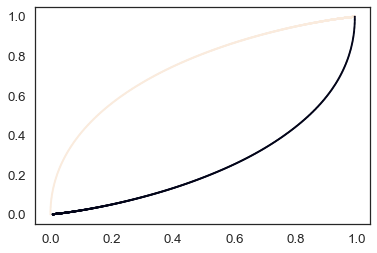

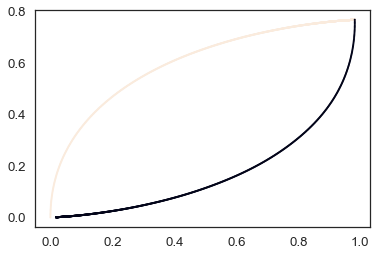

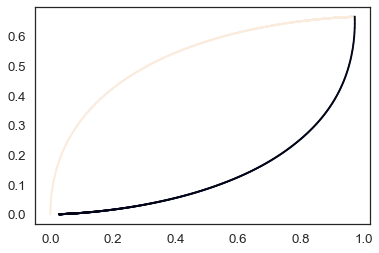

In [394]:
sim_data = []
sns.set_theme(context='notebook', style='white', palette='viridis', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)
for alpha, beta, gamma in [(2, 2, 2), (2, 2.6, 2), (2, 3, 2)]:
    sim_data.append(simulate_kinetics("gene000", alpha, beta, gamma, start_u=0, start_s=0, n_cells=2000, start_pct=0, end_pct=99.9, noise_level =0, plot=True))

alpha, beta, gamma = 2, 2, 2


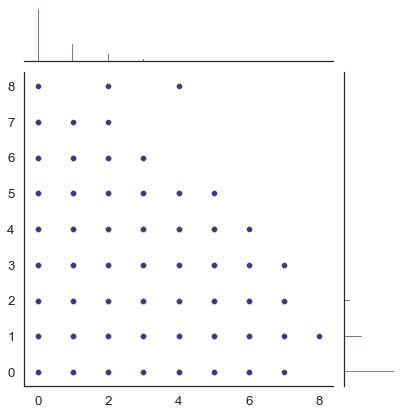

alpha, beta, gamma = 2, 2.6, 2


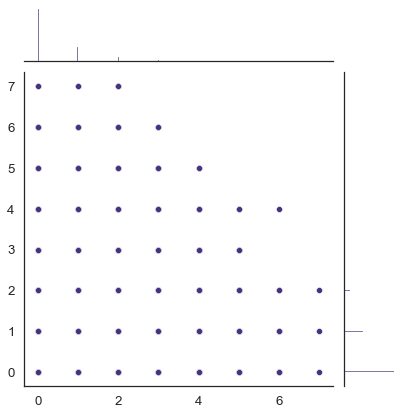

alpha, beta, gamma = 2, 3, 2


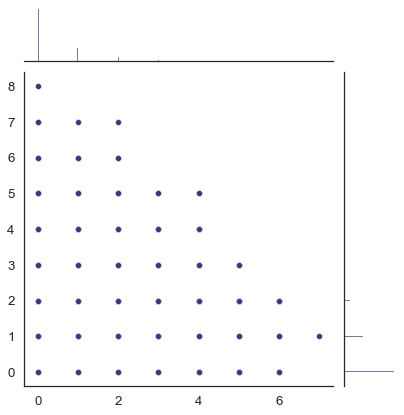

In [395]:
for one_gene in sim_data:
    alpha = one_gene['alpha'][0]
    beta = one_gene['beta'][0]
    gamma = one_gene['gamma'][0]
    print(f"alpha, beta, gamma = {alpha}, {beta}, {gamma}")
    simulate_raw_reads(one_gene, n_generate=200, distr='Poisson', inplace=True)

    u_raw_poisson = np.array([i for i in one_gene['u_raw']])
    s_raw_poisson = np.array([i for i in one_gene['s_raw']])

    #plt.scatter(u_raw_poisson.flatten(), s_raw_poisson.flatten())
    sns.jointplot(x=u_raw_poisson.flatten(), y=s_raw_poisson.flatten())
    plt.show()

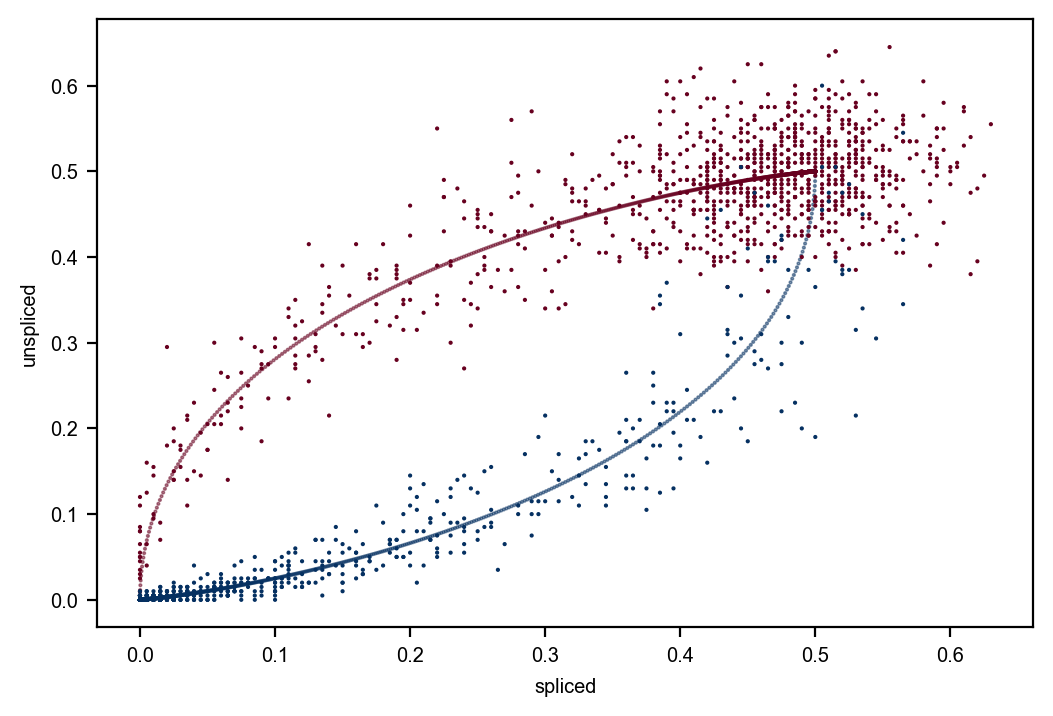

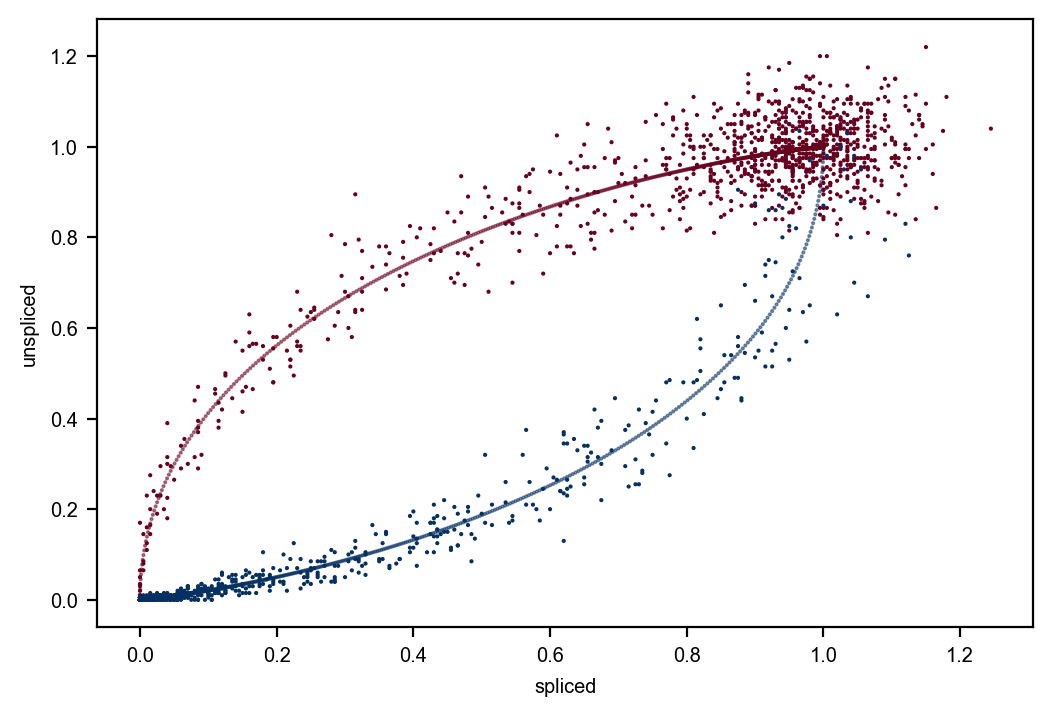

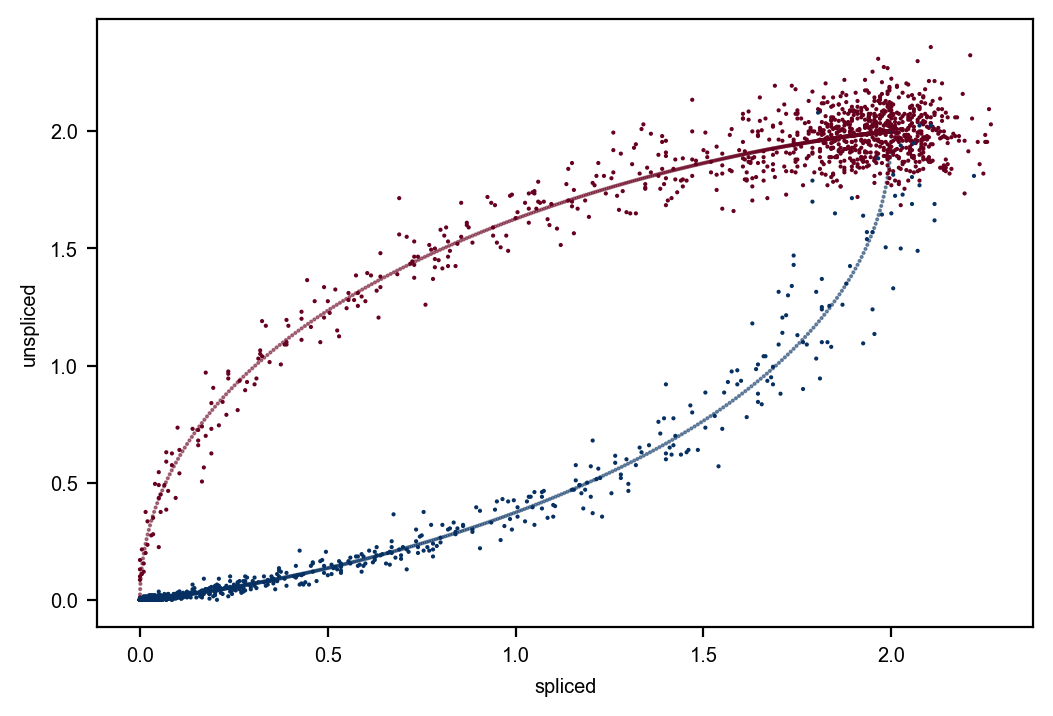

In [374]:
def calc_mean(df):
    u = df['u_raw']
    s = df['s_raw']

    u_mean = [np.mean(i) for i in u]
    s_mean = [np.mean(i) for i in s]
    plt.scatter(df['s0'], df['u0'], s=1, alpha = 0.5, c=df['alpha'])
    plt.scatter(s_mean, u_mean, s=1, c = df['alpha'])
    plt.xlabel('spliced')
    plt.ylabel('unspliced')
    plt.show()
for one_gene in sim_data:
    calc_mean(one_gene)
    

In [396]:
for one_gene in sim_data:
    print(calc_dropout(one_gene, col_handle='_raw'))

(0.66081, 0.6503075)
(0.71729, 0.64624)
(0.7454275, 0.643095)


In [368]:
for one_gene in sim_data:
    alpha = one_gene['alpha'][0]
    beta = one_gene['beta'][0]
    gamma = one_gene['gamma'][0]
    one_gene.to_csv(f"sim_one_gene_alpha{alpha}_beta{beta}_gamma{gamma}.csv")

### Simulate a range of rate parameters to form genes with 40%, 50%, 60%, 70% dropout ratio.

In [6]:
from tqdm import tqdm
import multiprocessing as mp

n_jobs = 24

def _scan(alpha, beta, gamma, end_pct):
    df = simulate_kinetics("gene000", alpha, beta, gamma, 0, 0, 2000, 0, end_pct, noise_level = 0.)
    simulate_raw_reads(df, n_generate=200, distr='Poisson', inplace=True)
    drop_ratio = calc_dropout(df, col_handle='_raw')
    return (alpha, beta, gamma, end_pct, *drop_ratio)

TASK = []
for end_pct in (99.9, 99.99, 99.999):
    for gamma in np.linspace(0.1, 1, 100):
        for beta in [gamma, 1.5*gamma]:
            for alpha in np.linspace(0.1, 1, 100):
                TASK.append((alpha, beta, gamma, end_pct))

with mp.Pool(n_jobs) as pool:
    PARA_DROP_RATIO = pool.starmap(_scan, tqdm(TASK))

#rates_drop_ratio_df = pd.DataFrame(PARA_DROP_RATIO, columns=['alpha', 'beta', 'gamma', 'end_pct', 'drop_ratio_u', 'drop_ratio_s'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [06:24<00:00, 156.18it/s]


In [7]:
# Drop the duplicate parameter set based on: alpha/beta, alpha/gamma, and end_pct
# e.g. (alpha, beta, gamma, end_pct) = (0.1, 0.1, 0.1, 99.)
# is duplicate of (0.5, 0.5, 0.5, 99.)

para_tank = []
PARA_DROP_RATIO_noDUP = []
for i in PARA_DROP_RATIO:
    j = (i[0]/i[1], i[0]/i[2], i[3])
    if not j in para_tank:
        para_tank.append(j)
        PARA_DROP_RATIO_noDUP.append(i)
    

In [8]:
len(PARA_DROP_RATIO_noDUP)

47154

In [9]:
np_para = np.array(PARA_DROP_RATIO_noDUP)

para = dict()
tol = 0.03
for drop_S in np.linspace(0.4, 0.7, 4):
    for drop_U in [drop_S, drop_S+0.1]:
        drop_U = round(drop_U, 1)
        para[(drop_U, drop_S)] = np_para[np.logical_and(np.abs(np_para[:,4] - drop_U) < tol , np.abs(np_para[:,5] - drop_S) < tol), :4]

In [424]:
# sort by the end_pct
for drop in para:
    a = para[drop]
    para[drop] = a[a[:, 3].argsort()]

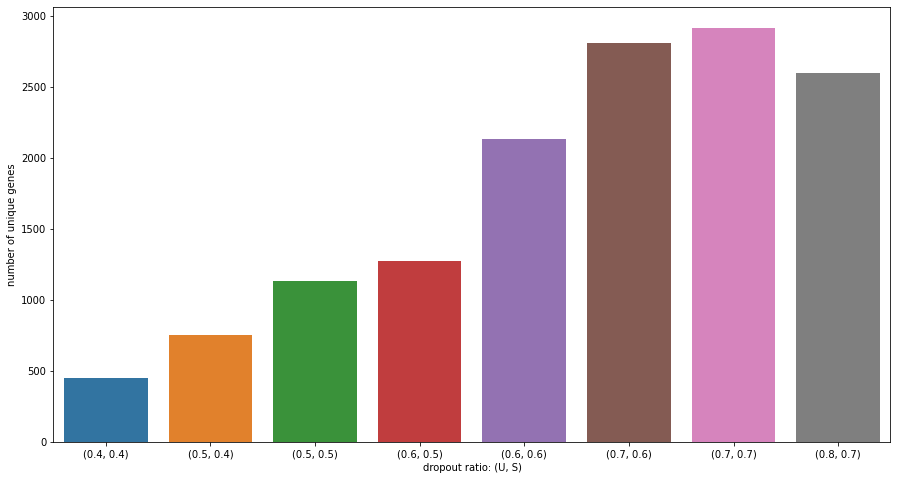

In [10]:
para_range = np.array([(i, len(para[i])) for i in para])
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=para_range[:, 0], y=para_range[:, 1])
plt.xlabel("dropout ratio: (U, S)")
plt.ylabel("number of unique genes")
plt.show()

In [11]:
def simulate(gene_name, alpha, beta, gamma, end_pct):

    alpha = float(alpha)
    beta = float(beta)
    gamma = float(gamma)
    end_pct = float(end_pct)
    
    df = perfect_cycle(gene_name, alpha, beta, gamma, 0, 0, 2000, 0, end_pct, noise_level = 0.)
    simulate_raw_reads(df, n_generate=200, distr='Poisson', inplace=True)
    drop_ratio = calc_dropout(df, col_handle='_raw')
    return df

def simulate_drop(drop, para, n_jobs=10):
    n_paras = len(para[drop])
    n_genes = 1000

    draw = np.random.randint(0, high=n_paras, size=n_genes)
    draw_paras = para[drop][draw, :]
    gene_name = np.array([f"drop{drop[0]}_{drop[1]}_gene{gene_id:04d}" for gene_id in range(n_genes)])[:, None]
    TASK = np.append(gene_name, draw_paras, axis=1)
    with mp.Pool(n_jobs) as pool:
        dfs = pool.starmap(simulate, tqdm(TASK, desc=f"Simulating genes for dropout ratio: {drop}"))
        
    return pd.concat(dfs)

In [12]:
dfs = [simulate_drop(drop, para, n_jobs=24) for drop in para]

Simulating genes for dropout ratio: (0.8, 0.7): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.51it/s]


In [32]:
dfs[0].set_index("gene_name")

,u0,s0,u1,s1,alpha,beta,gamma,u_raw,s_raw,u_sim_mean,s_sim_mean
gene_name,,,,,,,,,,,
drop0.4_0.4_gene0000,0.000000,0.000000,0.000609,0.000000,0.609091,0.163636,0.163636,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000,0.000
drop0.4_0.4_gene0000,0.034178,0.000157,0.034782,0.000163,0.609091,0.163636,0.163636,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.040,0.000
drop0.4_0.4_gene0000,0.068043,0.000626,0.068641,0.000637,0.609091,0.163636,0.163636,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.065,0.000
drop0.4_0.4_gene0000,0.101596,0.001399,0.102189,0.001416,0.609091,0.163636,0.163636,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090,0.005
drop0.4_0.4_gene0000,0.134842,0.002472,0.135429,0.002494,0.609091,0.163636,0.163636,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.140,0.010
...,...,...,...,...,...,...,...,...,...,...,...
drop0.4_0.4_gene0999,0.000401,0.004062,0.000401,0.004061,0.000000,0.127273,0.127273,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000,0.005
drop0.4_0.4_gene0999,0.000397,0.004028,0.000397,0.004028,0.000000,0.127273,0.127273,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000,0.015
drop0.4_0.4_gene0999,0.000394,0.003995,0.000393,0.003994,0.000000,0.127273,0.127273,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000,0.000


In [34]:
for df in dfs:
    name = "_".join(df.gene_name.iloc[0].split("_")[:2])
    df.reset_index().to_feather(f"simulation_{name}.feat")

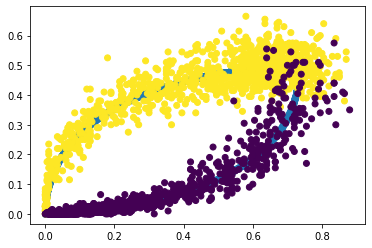

In [19]:
df = dfs[-1]
gene = df[df['gene_name']=='drop0.8_0.7_gene0000']

plt.scatter(x=gene['s0'], y=gene['u0'])

plt.scatter(x=gene['s_sim_mean'], y=gene['u_sim_mean'], c=gene['alpha'])

plt.show()

Next, we randomly shift cells for some genes (in chunks). 

In [87]:
def phase_shift(data, n_chunks = None, shift_phase_perc = None):
    # data is a list of 2  expression arrays: n_genes x n_cells
    U_data = data[0]
    S_data = data[1]

    n_genes = S_data.shape[0]
    n_cells = S_data.shape[1]
    
    shift = shift_phase_perc/100*n_cells
    shifts = [i*int(np.random.rand()*shift) for i in range(n_chunks)]
    U_chunks = np.array_split(U_data, n_chunks)
    S_chunks = np.array_split(S_data, n_chunks)


    U_chunks_shifted = []
    S_chunks_shifted = []
    for i in range(n_chunks):
        new_cell_index = [(j+shifts[i]) % n_cells for j in range(n_cells)]
        U_chunks_shifted.append(U_chunks[i][:, new_cell_index])
        S_chunks_shifted.append(S_chunks[i][:, new_cell_index])
    data_shifted = [np.concatenate(U_chunks_shifted, axis=0), np.concatenate(S_chunks_shifted, axis=0)]
    return data_shifted

In [88]:
def generate_cell(df, n_chunks=3, shift_phase_perc=30, plot=True):

    n_genes = len(df['gene_name'].drop_duplicates())

    U_drop_ratio = df['gene_name'].values[0][4:].split("_")[0]
    S_drop_ratio = df['gene_name'].values[0][4:].split("_")[1]


    n_cells = 2000
    skip = 40
    n_generate = len(df['s_raw'].iloc[0])

    s0_d = np.array([np.array(i[::skip]) for i in df['s_raw']])
    s0_d_reshape = np.reshape(s0_d, (n_genes, int(n_cells*n_generate/skip)))

    u0_d = np.array([np.array(i[::skip]) for i in df['u_raw']])
    u0_d_reshape = np.reshape(u0_d, (n_genes, int(n_cells*n_generate/skip)))
    
    u0_d_shift, s0_d_shift = phase_shift([u0_d_reshape, s0_d_reshape], 
                                         n_chunks=n_chunks, 
                                         shift_phase_perc=shift_phase_perc)
    if plot:
        fig, axes = plt.subplots(ncols=2, figsize=(24,10))
        sns.heatmap(u0_d_shift[::10, ::10], ax=axes[0], cmap='rocket_r')
        sns.heatmap(s0_d_shift[::10, ::10], ax=axes[1], cmap='rocket_r')
        axes[0].set_title(f"Unspliced at dropout ratio {U_drop_ratio}")
        axes[1].set_title(f"Spliced at dropout ratio {S_drop_ratio}")
        axes[0].set_axis_off()
        axes[1].set_axis_off()
        plt.savefig(f"expression_heatmap_u{U_drop_ratio}_s{S_drop_ratio}.pdf", dpi=600)

    
    return u0_d_shift, s0_d_shift, U_drop_ratio, S_drop_ratio

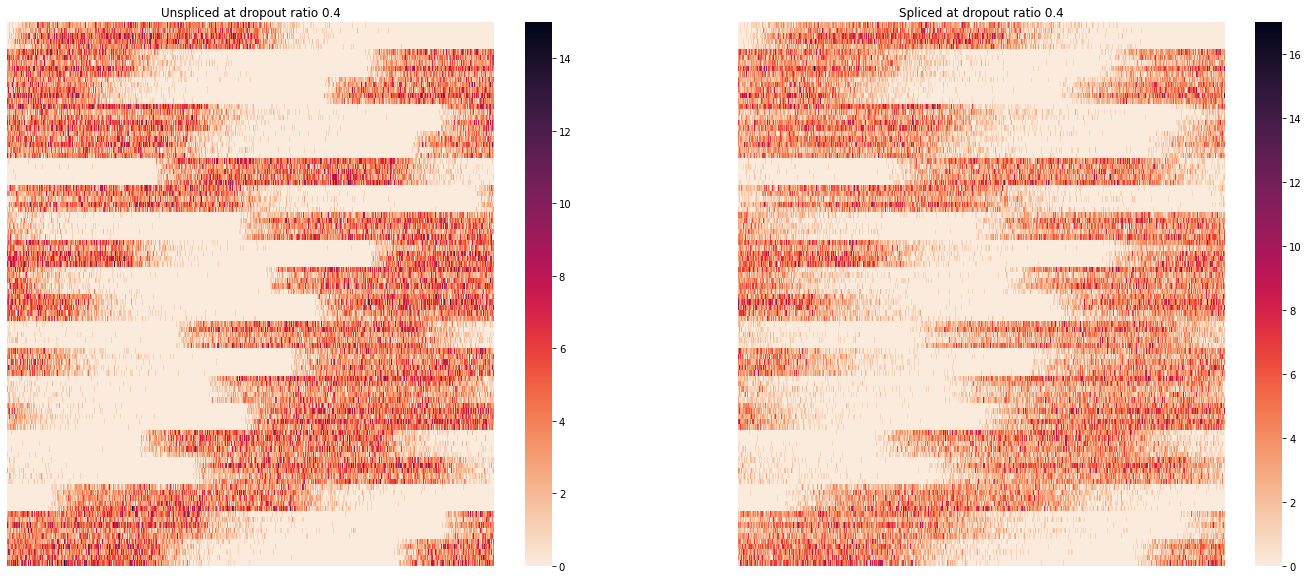

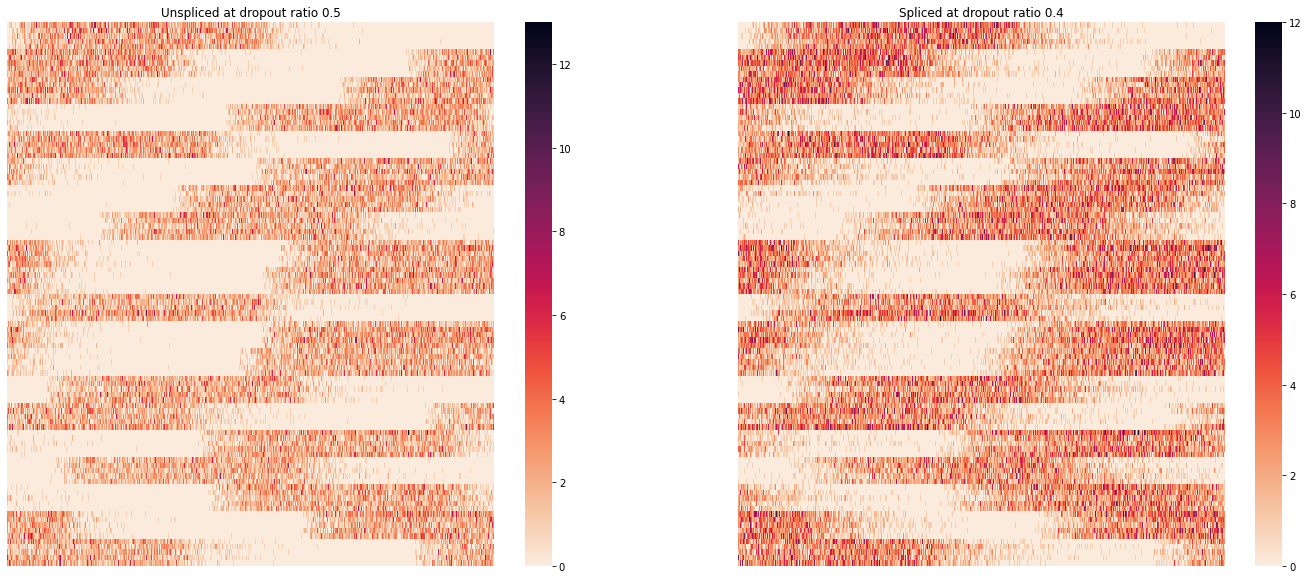

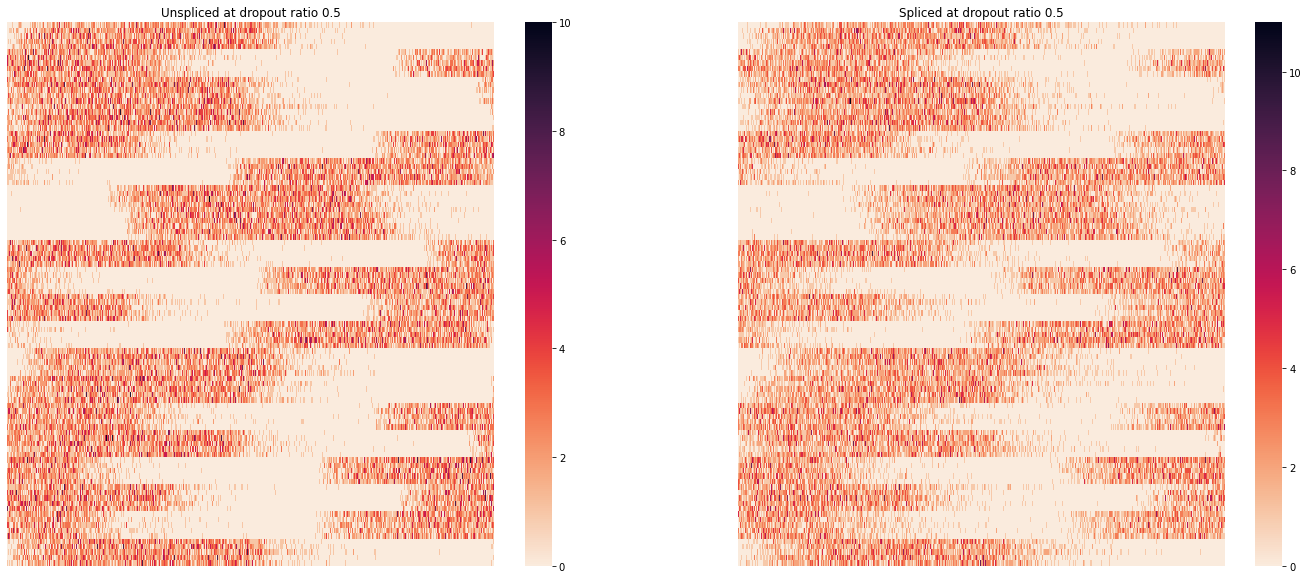

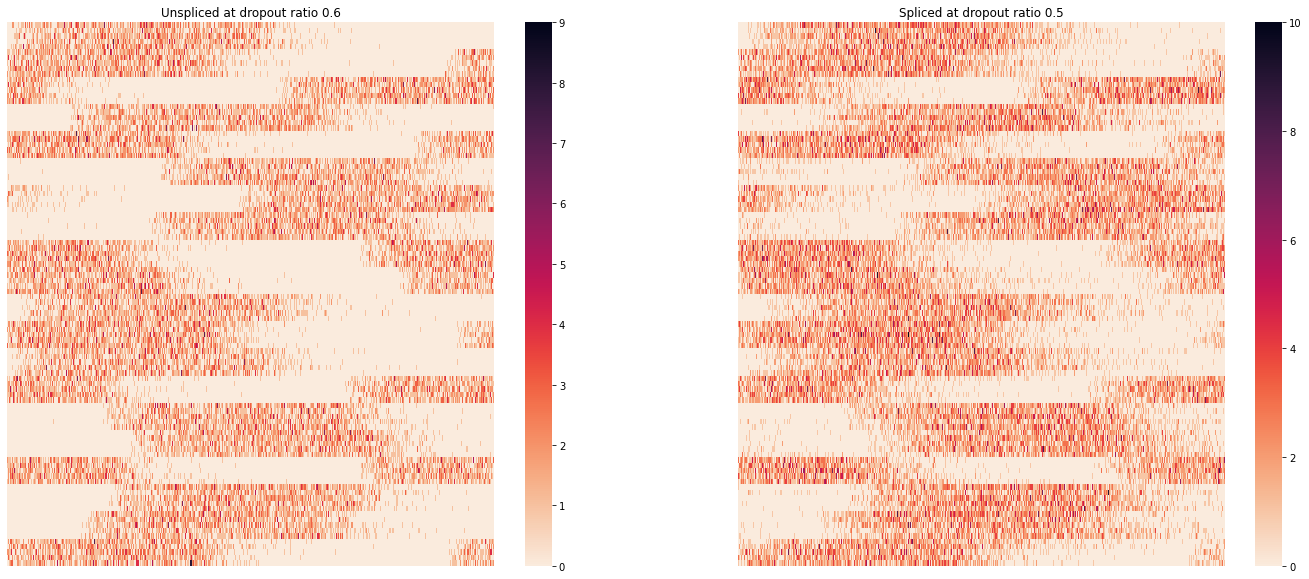

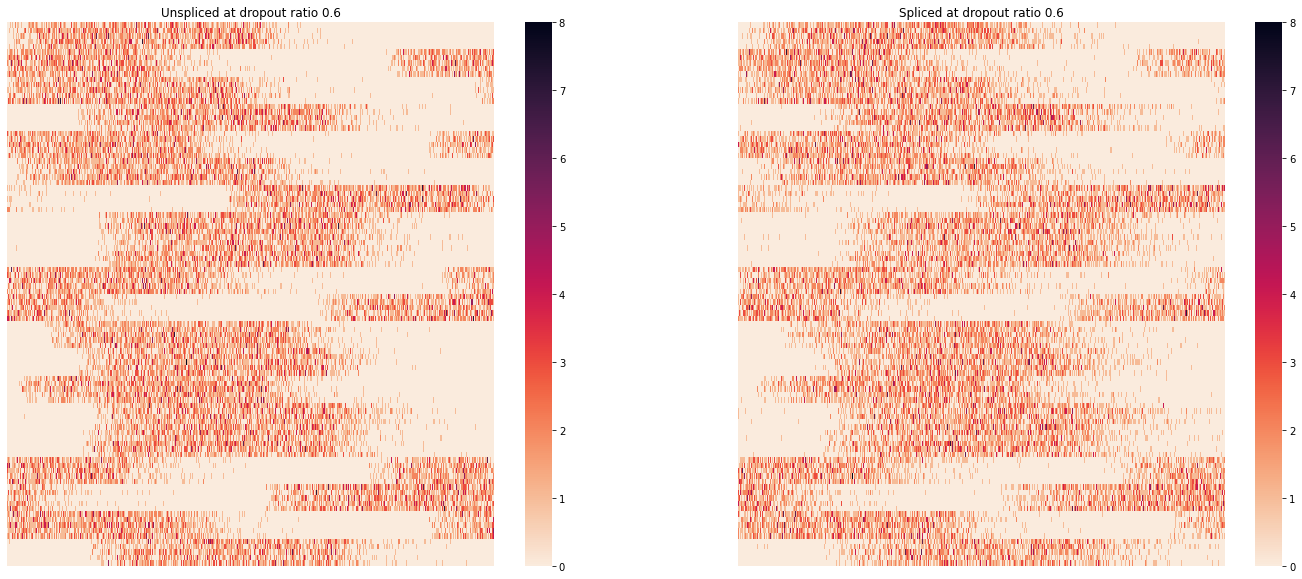

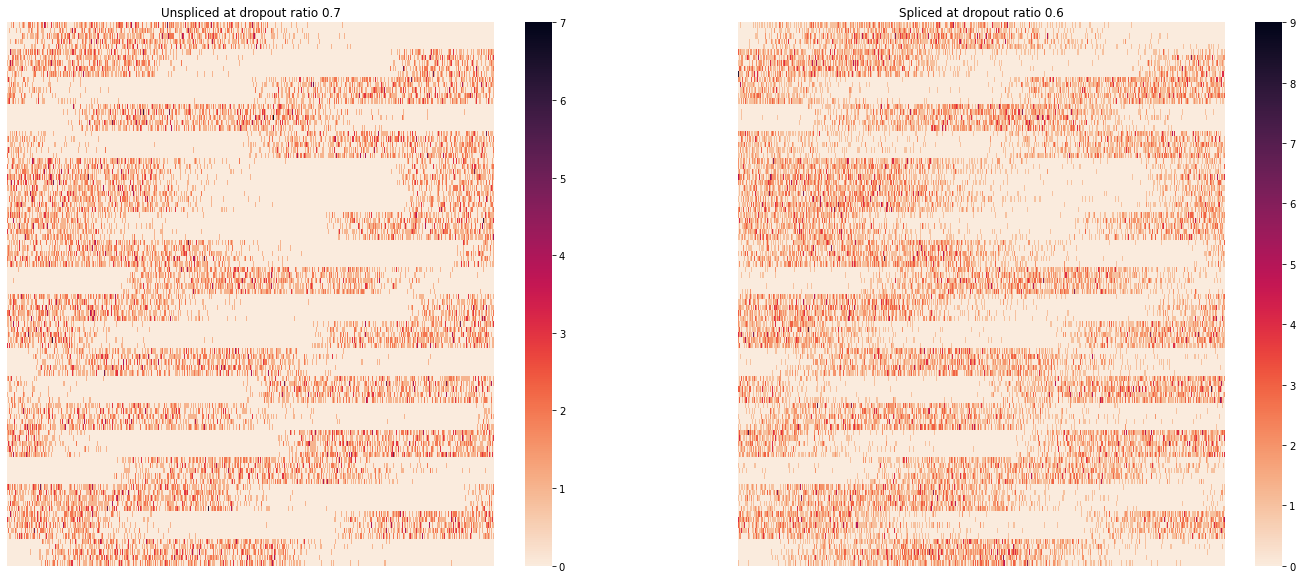

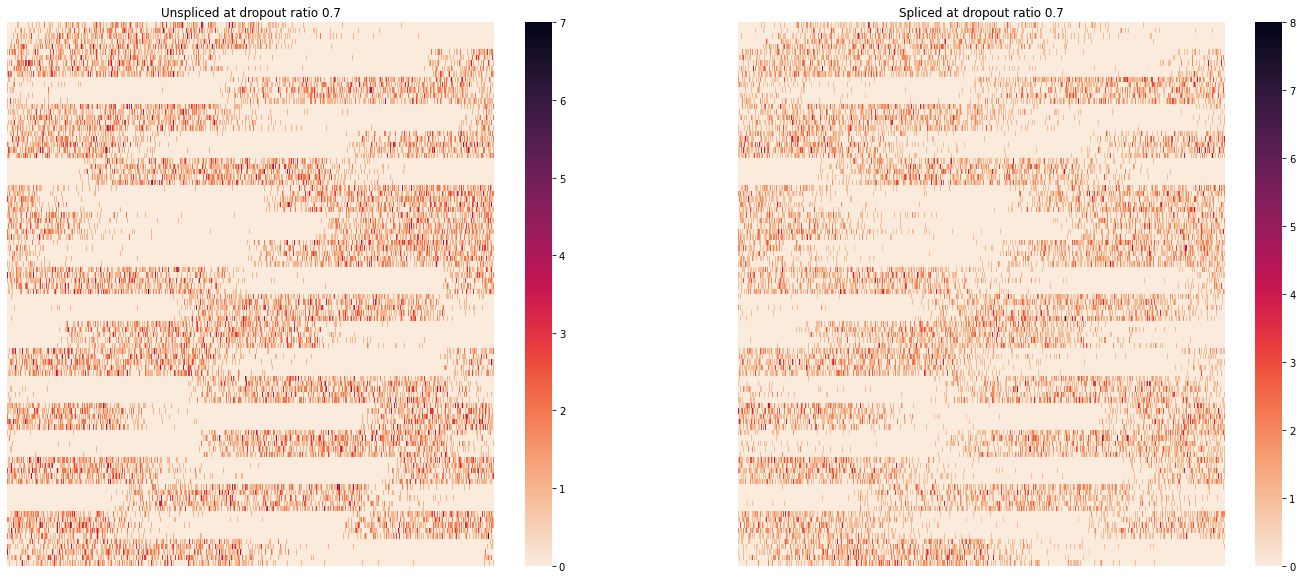

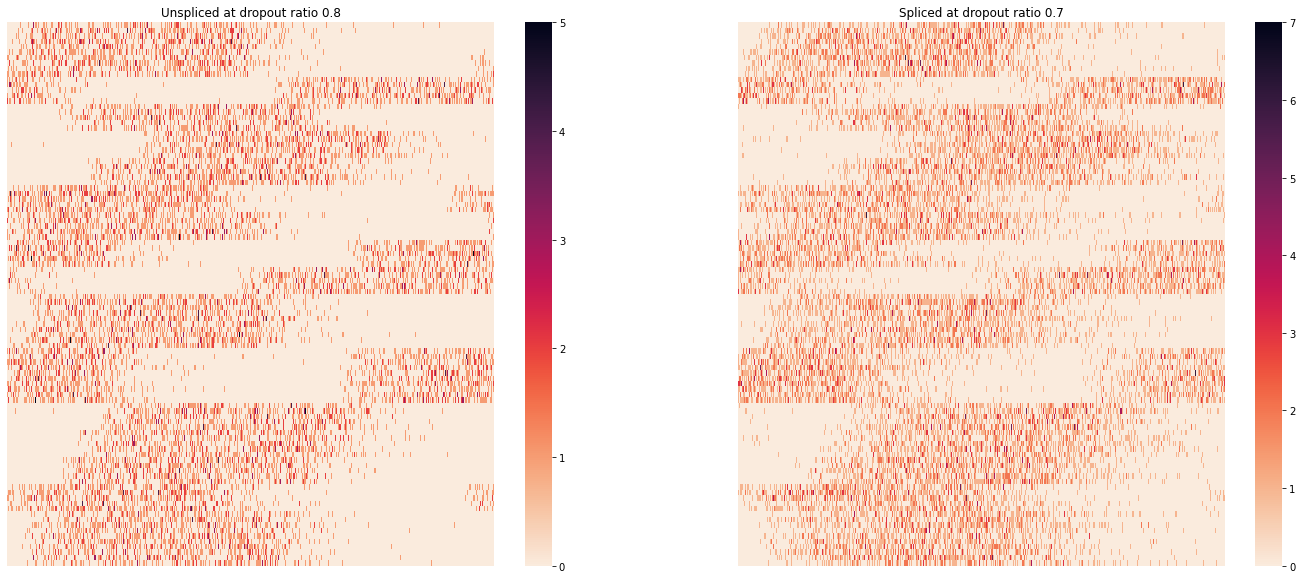

In [89]:
shifted_expression = {}
i = 1
for df in dfs:
    np.random.seed(i+2022)
    shifted = generate_cell(df, n_chunks=20, shift_phase_perc=30)
    shifted_expression[(shifted[2], shifted[3])] = (shifted[0], shifted[1])
    i += 19

In [90]:
Example_U40, Example_S40 = shifted_expression['0.4', '0.4']

In [91]:
Example_U70, Example_S70 = shifted_expression['0.7', '0.7']

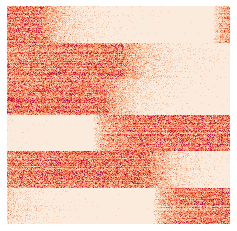

In [131]:
fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(Example_U40[100:400:, 500:7000:10], cmap='rocket_r', vmax=16, cbar=None)
plt.axis("off")
plt.savefig("u40.png", dpi=300)
plt.show()



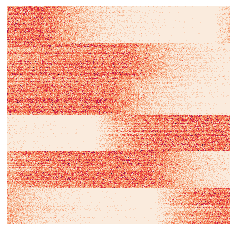

In [129]:
fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(Example_S40[100:400:, 500:7000:10], cmap='rocket_r', vmax=16, cbar=None)
plt.axis("off")
plt.savefig("s40.png", dpi=300)
plt.show()



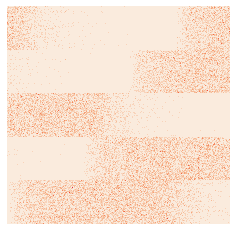

In [125]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(Example_U70[350:600:, 1000:8000:10], cmap='rocket_r', vmax=16, cbar=None)
plt.axis("off")
plt.savefig("u70.png", dpi=300)
plt.show()



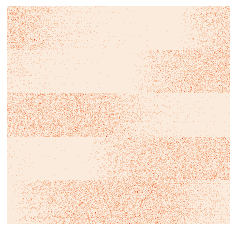

In [130]:
fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(Example_S70[350:600:, 1000:8000:10], cmap='rocket_r', vmax=16, cbar=None)
plt.axis("off")
plt.savefig("s70.png", dpi=300)
plt.show()



# dropout ratio in real data

In [180]:
import scvelo as scv

100%|██████████| 463M/463M [01:05<00:00, 7.38MB/s] 


In [258]:
def calc_dropout_realdata(adata, threshold=0):

    u_raw = adata.layers['unspliced'].toarray()
    s_raw = adata.layers['spliced'].toarray()

    Mu = adata.layers['Mu']
    Ms = adata.layers['Ms']

    # count as 0 only when it's < threshold  when in raw but its moment is > threshold
    u_zero = np.logical_and(Mu>threshold, u_raw<=threshold)
    s_zero = np.logical_and(Ms>threshold, s_raw<=threshold)
    
    return np.mean(u_zero), np.mean(s_zero)

In [287]:
gast = scv.datasets.gastrulation_erythroid()
scv.pp.filter_and_normalize(gast, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(gast, n_pcs=30, n_neighbors=30)
gast.var[gast.var['means'] > 5]

,Accession,Chromosome,End,Start,Strand,MURK_gene,Δm,scaled Δm,gene_count_corr,means,dispersions,dispersions_norm,highly_variable
index,,,,,,,,,,,,,
Hba-x,ENSMUSG00000055609,11,32278116,32276400,+,True,0.004803,1.060738,-0.1538,5.678536,5.958082,1.000000,True
Hbb-bh1,ENSMUSG00000052217,7,103843164,103841637,-,True,0.000579,0.427912,-0.1666,6.201933,6.021302,1.000000,True
Hbb-y,ENSMUSG00000052187,7,103853216,103851749,-,True,0.000552,0.254151,-0.1232,5.151422,6.606504,0.707107,True


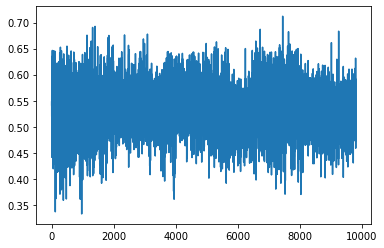

In [304]:
s = gast.layers['spliced']
u = gast.layers['unspliced']
ms = gast.layers['Ms']
mu = gast.layers['Mu']

len(ms[ms > 0]), len(ms)
tf = np.logical_and(ms>0, (s == 0).toarray())
plt.plot(np.mean(tf, axis=1))

In [303]:
calc_dropout_realdata(gast[:, 'Hba-x'], threshold=0.)

(ArrayView(0.47733062), ArrayView(0.1777891))

In [328]:
calc_dropout_realdata(gast[:, 'Smim1'], threshold=0.)

(ArrayView(0.56067244), ArrayView(0.10382068))

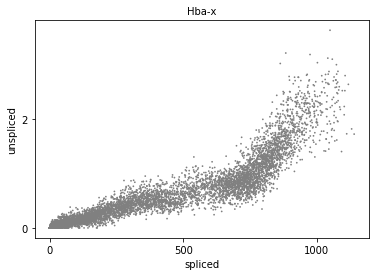

In [300]:
scv.pl.scatter(gast, 'Hba-x', x='Ms', y='Mu')

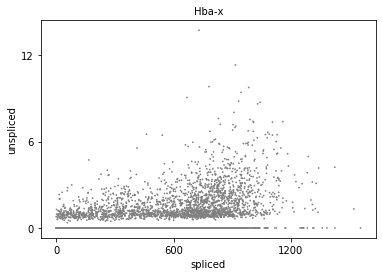

In [301]:
scv.pl.scatter(gast, 'Hba-x', x='spliced', y='unspliced')

In [302]:
calc_dropout_realdata(gast, threshold=0)

(0.5781544515036644, 0.5310553604954877)

In [306]:
panc = scv.datasets.pancreatic_endocrinogenesis()
scv.pp.filter_and_normalize(panc, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(panc, n_pcs=30, n_neighbors=30)
panc.var[panc.var['means'] > 5]

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


,highly_variable_genes,gene_count_corr,means,dispersions,dispersions_norm,highly_variable
index,,,,,,


In [311]:
calc_dropout_realdata(panc, threshold=0)

(0.5700354437229437, 0.6035771103896104)

In [316]:
import dynamo as dyn

In [314]:
DG = dyn.sample_data.DentateGyrus()

|-----> Downloading data to ./data/DentateGyrus.loom
|-----> [download] in progress: 100.0000%
|-----> [download] finished [348.3168s]


In [317]:
scv.pp.filter_and_normalize(DG, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(DG, n_pcs=30, n_neighbors=30)
DG.var[DG.var['means'] > 5]

Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


,Accession,Chromosome,End,Start,Strand,gene_count_corr,means,dispersions,dispersions_norm,highly_variable


In [319]:
calc_dropout_realdata(DG, threshold=0)

(0.4787283259210454, 0.5561939274144841)

In [320]:
hgFG = dyn.sample_data.hgForebrainGlutamatergic()

|-----> Downloading data to ./data/hgForebrainGlut.loom
|-----> [download] in progress: 100.0000%
|-----> [download] finished [230.3382s]


In [321]:
scv.pp.filter_and_normalize(hgFG, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(hgFG, n_pcs=30, n_neighbors=30)
hgFG.var[hgFG.var['means'] > 5]

Filtered out 26764 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


,Accession,Chromosome,End,Start,Strand,cell_cycle_genes,gene_count_corr,means,dispersions,dispersions_norm,highly_variable
MALAT1,ENSG00000251562,11,65273940,65265233,+,False,-0.2485,5.662816,4.295842,1.0,True


In [323]:
calc_dropout_realdata(hgFG, threshold=0)

(0.6625311046511628, 0.641240988372093)